In [69]:
import numpy as np
import pandas as pd
#import logging
#from sklearn.decomposition import TruncatedSVD
#from sklearn.linear_model import LinearRegression
#from sklearn.metrics import mean_squared_error

import scanpy as sc
import scipy
import anndata as ad
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import plotly

In [70]:
adata_all = ad.read_h5ad("data/GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad")
adata_all

AnnData object with n_obs × n_vars = 69249 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [71]:
adata_all = adata_all[adata_all.obs.ATAC_reads_in_peaks_frac >= 0.25]
adata_all = adata_all[adata_all.obs.ATAC_nCount_peaks >= 1000]

In [72]:
adata_all = adata_all[adata_all.obs.GEX_n_genes <= 2410.6, :] # cut cells with values above 95% quantile
adata_all = adata_all[adata_all.obs.GEX_n_counts <= 4880., :] # cut cells with values above 95% quantile
adata_all = adata_all[adata_all.obs.GEX_pct_counts_mt <= 5, :] # cut when mitochondrial percentage >5%

In [73]:
adata_all = adata_all[adata_all.obs.GEX_pseudotime_order.notna()]
# about 7000 cells left

In [74]:
adata_gex = adata_all[:,adata_all.var.feature_types == "GEX"]
adata_atac = adata_all[:,adata_all.var.feature_types == 'ATAC']

In [75]:
adata_gex.X = adata_gex.layers['counts']

In [76]:
np.unique(adata_gex.X[0].A)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   9.,  10.,  11.,
        13.,  21.,  37.,  49., 206.], dtype=float32)

In [77]:
# Normalize each cell by total counts over all genes, so that every cell has the same total count after normalization.
sc.pp.normalize_total(adata_gex, target_sum=1e4)
np.unique(adata_gex.X[0].A)

/Users/mariebecker/Documents/Uni/Bachelorarbeit/Atac_RNA-seq_project/Atac-RNA-seq-temporal-connection/bt/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


array([   0.      ,    5.170631,   10.341262,   15.511892,   20.682524,
         25.853155,   31.023785,   36.194416,   46.53568 ,   51.70631 ,
         56.87694 ,   67.2182  ,  108.58325 ,  191.31334 ,  253.36092 ,
       1065.15    ], dtype=float32)

In [78]:
sc.pp.log1p(adata_gex)
np.unique(adata_gex.X[0].A)

array([0.       , 1.8198011, 2.4284475, 2.804081 , 3.0765066, 3.2903833,
       3.4664788, 3.6161587, 3.8614805, 3.9647353, 4.058319 , 4.2227116,
       4.6966844, 5.259126 , 5.538754 , 6.9718094], dtype=float32)

In [79]:
sc.pp.highly_variable_genes(adata_gex, batch_key = 'batch')

/Users/mariebecker/Documents/Uni/Bachelorarbeit/Atac_RNA-seq_project/Atac-RNA-seq-temporal-connection/bt/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/Users/mariebecker/Documents/Uni/Bachelorarbeit/Atac_RNA-seq_project/Atac-RNA-seq-temporal-connection/bt/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/Users/mariebecker/Documents/Uni/Bachelorarbeit/Atac_RNA-seq_project/Atac-RNA-seq-temporal-connection/bt/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from

In [80]:
adata_gex.var

,feature_types,gene_id,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
AL627309.5,GEX,ENSG00000241860,False,0.017919,1.050725,-0.040598,2,False
LINC01409,GEX,ENSG00000237491,False,0.149275,1.904662,0.429100,5,False
LINC01128,GEX,ENSG00000228794,True,0.513148,2.105469,0.549649,6,False
NOC2L,GEX,ENSG00000188976,False,0.154684,1.802976,0.159345,2,False
KLHL17,GEX,ENSG00000187961,False,0.017102,1.289216,-0.099087,2,False
...,...,...,...,...,...,...,...,...
MT-ND5,GEX,ENSG00000198786,False,1.241808,2.131915,0.015343,5,False
MT-ND6,GEX,ENSG00000198695,False,0.536325,1.969676,0.288823,5,False
MT-CYB,GEX,ENSG00000198727,False,1.583947,2.251672,-0.208660,3,False
AL592183.1,GEX,ENSG00000273748,False,0.233679,1.680848,-0.397362,2,False


In [81]:
# Compute HVG
# sc.pp.highly_variable_genes(adata, batch_key='batch')
adata_gex.var = adata_gex.var[['gene_id','highly_variable','highly_variable_nbatches']]
adata_gex.raw = adata_gex

# Filter by HVG
num_hvg_genes = 3000
batch_msk = np.array(adata_gex.var.highly_variable_nbatches > 1)
hvg = adata_gex.var[batch_msk].sort_values('highly_variable_nbatches').tail(num_hvg_genes).index # determine num_hvg_genes most variable genes, list of gene names
adata_gex.var['highly_variable'] = [g in hvg for g in adata_gex.var.index] # adds True or False in highly variable column, True if gene in hvg
adata_gex.var = adata_gex.var[['gene_id','highly_variable','highly_variable_nbatches']] #no effect??
adata_gex = adata_gex[:,hvg] # 2 lines above not really necessary


/var/folders/l3/cr7pvqjn2054djbp5cf7qbd40000gn/T/ipykernel_9730/875699604.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_gex.var['highly_variable'] = [g in hvg for g in adata_gex.var.index] # adds True or False in highly variable column, True if gene in hvg


In [82]:
# scale data to unit variance and zero mean
sc.pp.scale(adata_gex)
sc.tl.pca(adata_gex, svd_solver='arpack')

/Users/mariebecker/Documents/Uni/Bachelorarbeit/Atac_RNA-seq_project/Atac-RNA-seq-temporal-connection/bt/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [83]:
import scanpy.external as sce
sce.pp.harmony_integrate(adata_gex, 'batch', adjusted_basis='X_pca')

2022-04-26 11:26:14,158 - harmonypy - INFO - Iteration 1 of 10
2022-04-26 11:26:15,940 - harmonypy - INFO - Iteration 2 of 10
2022-04-26 11:26:17,216 - harmonypy - INFO - Iteration 3 of 10
2022-04-26 11:26:18,531 - harmonypy - INFO - Iteration 4 of 10
2022-04-26 11:26:19,745 - harmonypy - INFO - Iteration 5 of 10
2022-04-26 11:26:20,667 - harmonypy - INFO - Converged after 5 iterations


In [84]:
# Run UMAP
sc.pp.neighbors(adata_gex)
sc.tl.umap(adata_gex)

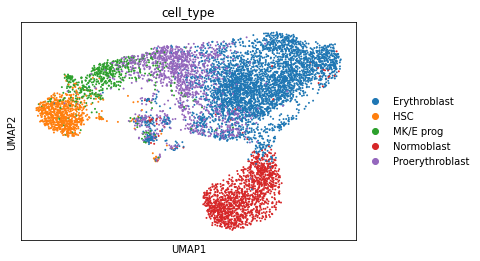

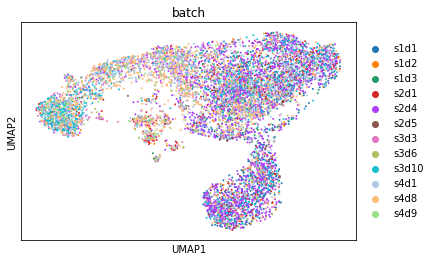

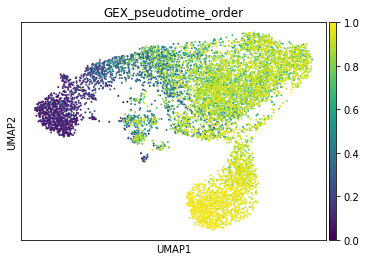

In [85]:
sc.pl.umap(adata_gex, color='cell_type', save='_gex_cell_type.png')
sc.pl.umap(adata_gex, color='batch', save='_gex_batch.png')
sc.pl.umap(adata_gex, color='GEX_pseudotime_order', save = '_gex_pseudotime_order.png')

In [86]:
sc.tl.leiden(adata_gex) #leiden clustering to identify strange cells

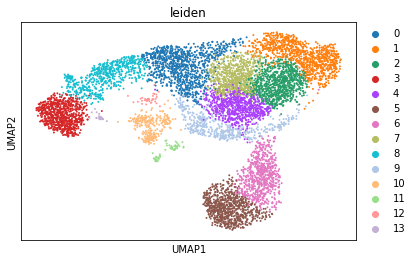

In [87]:
sc.pl.umap(adata_gex, color='leiden')

In [88]:
adata_gex

AnnData object with n_obs × n_vars = 7846 × 3000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'leiden'
    var: 'gene_id', 'highly_variable', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'cell_type_colors', 'batch_colors', 'leiden', 'leiden_colors'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [89]:
# filter out unwanted cell clusters
adata_gex = adata_gex[np.logical_and(adata_gex.obs.leiden != '10', adata_gex.obs.leiden != '11')]
adata_gex = adata_gex[adata_gex.obs.leiden != '12']

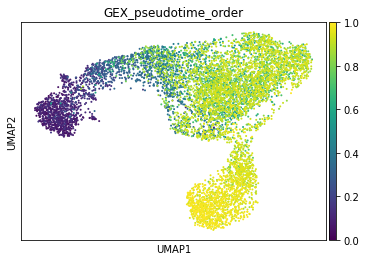

In [90]:
sc.pl.umap(adata_gex, color='GEX_pseudotime_order')

In [91]:
adata_gex

View of AnnData object with n_obs × n_vars = 7473 × 3000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'leiden'
    var: 'gene_id', 'highly_variable', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'cell_type_colors', 'batch_colors', 'leiden', 'leiden_colors'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [92]:
# raw: keeps infos about vars, changes with changes in obs
adata_gex = adata_gex.raw.to_adata()

In [93]:
# Compute HVG after removing 3 leiden clusters --> recomputing highly variable genes overwrites former values
sc.pp.highly_variable_genes(adata_gex, batch_key='batch')
adata_gex.var = adata_gex.var[['gene_id','highly_variable','highly_variable_nbatches']]
adata_gex.raw = adata_gex

# Filter by HVG
num_hvg_genes = 2048
batch_msk = np.array(adata_gex.var.highly_variable_nbatches > 1)
hvg = adata_gex.var[batch_msk].sort_values('highly_variable_nbatches').tail(num_hvg_genes).index # determine num_hvg_genes most variable genes, list of gene names
adata_gex.var['highly_variable'] = [g in hvg for g in adata_gex.var.index] # adds True or False in highly variable column, True if gene in hvg
adata_gex.var = adata_gex.var[['gene_id','highly_variable','highly_variable_nbatches']] #no effect??
adata_gex = adata_gex[:,hvg] # 2 lines above not really necessary

/Users/mariebecker/Documents/Uni/Bachelorarbeit/Atac_RNA-seq_project/Atac-RNA-seq-temporal-connection/bt/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/Users/mariebecker/Documents/Uni/Bachelorarbeit/Atac_RNA-seq_project/Atac-RNA-seq-temporal-connection/bt/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/Users/mariebecker/Documents/Uni/Bachelorarbeit/Atac_RNA-seq_project/Atac-RNA-seq-temporal-connection/bt/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from

### Find highly variable ATAC peaks

In [94]:
adata_atac=adata_all[:,adata_all.var.feature_types=='ATAC']

In [95]:
#repeat leiden filtering on atac data
adata_atac = adata_atac[adata_gex.obs.index,:] # adata_gex.obs.index gives cell names


In [96]:
# use original instead of binarized data
adata_atac.X = adata_atac.layers['counts'] #needed nearly 2 min
np.unique(adata_atac.X[0].A)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8., 10., 12., 14.],
      dtype=float32)

In [97]:
np.max(np.sum(adata_atac.X, axis = 0))

23232.0

In [98]:
# Normalize each cell by total counts over all peaks, so that every cell has the same total count after normalization.
sc.pp.normalize_total(adata_atac, target_sum = 10e4)
np.unique(adata_atac.X[0].A)

/Users/mariebecker/Documents/Uni/Bachelorarbeit/Atac_RNA-seq_project/Atac-RNA-seq-temporal-connection/bt/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


array([  0.      ,  11.070519,  22.141039,  33.21156 ,  44.282078,
        55.352596,  66.42312 ,  77.49364 ,  88.564156, 110.70519 ,
       132.84624 , 154.98727 ], dtype=float32)

In [99]:
sc.pp.log1p(adata_atac)
np.unique(adata_atac.X[0].A)

array([0.       , 2.490766 , 3.1416075, 3.5325637, 3.8129113, 4.031628 ,
       4.210988 , 4.3630176, 4.494955 , 4.715863 , 4.896692 , 5.0497746],
      dtype=float32)

In [100]:
# calculate highly variable ATAC peaks
sc.pp.highly_variable_genes(adata_atac, batch_key='batch')

/Users/mariebecker/Documents/Uni/Bachelorarbeit/Atac_RNA-seq_project/Atac-RNA-seq-temporal-connection/bt/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/Users/mariebecker/Documents/Uni/Bachelorarbeit/Atac_RNA-seq_project/Atac-RNA-seq-temporal-connection/bt/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/Users/mariebecker/Documents/Uni/Bachelorarbeit/Atac_RNA-seq_project/Atac-RNA-seq-temporal-connection/bt/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from

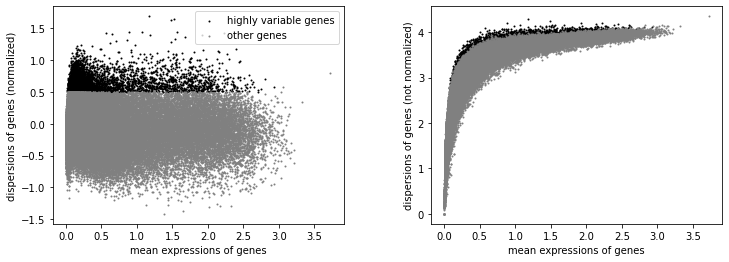

In [101]:
sc.pl.highly_variable_genes(adata_atac)

In [102]:
# choose 32768 most variable ATAC peaks

adata_atac.var = adata_atac.var[['highly_variable','highly_variable_nbatches']]
adata_atac.raw = adata_atac

# Filter by highly variable peaks
num_hvp_peaks = 32768
batch_msk = np.array(adata_atac.var.highly_variable_nbatches > 1)
hvp = adata_atac.var[batch_msk].sort_values('highly_variable_nbatches').tail(num_hvp_peaks).index # determine num_hvg_genes most variable genes, list of gene names
adata_atac.var['highly_variable'] = [g in hvp for g in adata_atac.var.index] # adds True or False in highly variable column, True if gene in hvg
adata_atac.var = adata_atac.var[['highly_variable','highly_variable_nbatches']] #no effect??
adata_atac = adata_atac[:,hvp] # 2 lines above not really necessary


In [104]:
results_file_gex = 'write/filtered_data_gex.h5ad'
adata_gex.write(results_file_gex)

results_file_atac = 'write/filtered_data_atac.h5ad'
adata_atac.write(results_file_atac)

### Alternatives how to choose ATAC peaks, not used

In [55]:
# choose 50 000 peaks which are active in most cells
n_cells = np.array(np.sum(adata_atac.X, axis = 0))[0]
adata_atac_most_cells = adata_atac[:,list(np.argsort(n_cells)[-50000:])]
adata_atac_most_cells

View of AnnData object with n_obs × n_vars = 7473 × 50000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

<BarContainer object of 100 artists>

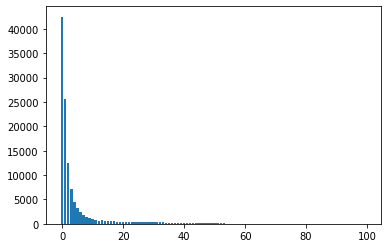

In [56]:
a = np.histogram(n_cells/len(adata_atac.obs), bins = 100)
plt.bar(range(100), a[0])

In [57]:
# choose peaks which are found in more dann 5% of cells
per_expressed_cells = 0.01
n_cells = np.array(np.sum(adata_atac.X, axis = 0))[0]
peak_indices = np.where(n_cells > per_expressed_cells*len(adata_atac.obs))[0]
adata_atac_f = adata_atac[:,peak_indices]
adata_atac_f

View of AnnData object with n_obs × n_vars = 7473 × 55045
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'